In [1]:
# For data prep
import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

# For PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import bisect

# For Clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# For plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotnine import *

# For writeup
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# 1. Loading database

In [2]:
with create_engine('sqlite:///ulam.db').connect() as conn:
    df_ing = pd.read_sql("""
    SELECT * FROM rekado
    """, conn)
    
display(df_ing)

,dish_name,yeast,wrapper,worcestershire_sauce,winged_bean,vinegar,turmeric,tomato,tofu,toasted_rice_powder,...,shrimp,pineapple,water,salt,rice,pork,corn,chicken,beef,banana
0,Sinarsahang Manok,0.0,0.0,0.0,0.0,0.0000,0.0,2.5,0.0,0.0,...,0.0,0.0,1.50,0.000000,0.0,0.0,0.000,680.389364,0.000000,0.0
1,Pinoy Chicken Curry Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.00,0.000000,0.0,0.0,0.000,907.185819,0.000000,0.0
2,Ketchup Fried Chicken,0.0,0.0,0.0,0.0,0.3125,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.000,3.000000,0.000000,0.0
3,Chicken Barbecue,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,2.000000,0.0,0.0,0.000,4.000000,0.000000,0.0
4,Chicken Paksiw Recipe,0.0,0.0,0.0,0.0,0.5000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.00,1.000000,0.0,0.0,0.000,453.592909,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Papaitan Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,8.00,0.156250,0.0,0.0,0.000,0.000000,226.796455,0.0
278,Morcon Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.005208,0.0,0.0,0.000,0.000000,907.185819,0.0
279,Beef Mechado Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,1.0,0.0,0.0,...,0.0,0.0,1.00,1.000000,0.0,0.0,0.000,0.000000,907.185819,0.0
280,Bulalo Recipe,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,4.25,0.000000,0.0,0.0,1.125,0.000000,907.185819,0.0


# 2. Data Prep

In [3]:
def drop_features(data, irrelevant_cols, skip_cols, p):
    """
    Drop features given a variance threshold

    Parameters
    ----------
    data : dataframe
        dataframe from which the columns will be dropped. May contain
    a mix of numeric and categorical columns. By default, categorical
    columns are label-encoded before getting the variance of the columns.

    irrelevant_cols : list
        list of column names. Column names in this list will be dropped
    permanently.

    skip_cols : list
        list of column names. Column names in this list will be kept by
    default and will not undergo variance thresholding.

    p : float
        variance threshold for dropping. A p = 0.01 would mean dropping
    columns where 99% of the values are similar.

    Returns
    -------
        dataframe in its original format, whose columns that did not
    satisfy the p threshold were dropped

    """
    orig_data = data.copy(deep=True)
    if irrelevant_cols is not None:
        print(f"Dropping irrelevant columns:\n{irrelevant_cols}")
        data = orig_data.drop(irrelevant_cols, axis=1)
    if skip_cols is not None:
        print(f"\nSkipping the following columns:\n{skip_cols}")
        data = data.drop(skip_cols, axis=1)

    num_data = pd.DataFrame(data.select_dtypes(include=np.number))
    cat_data = pd.DataFrame(data.select_dtypes(exclude=np.number))

    if cat_data.shape[1] != 0:
        cat_data = cat_data.apply(LabelEncoder().fit_transform)
        transformed_data = pd.concat([num_data, cat_data], axis=1)
    else:
        transformed_data = num_data

    # threshold=0.01 means dropping the column where 99% of values are similar.
    thresh = VarianceThreshold(threshold=p)
    thresh.fit_transform(transformed_data)
    ind = thresh.get_support(indices=True)
    cols_kept = list(transformed_data.columns[ind])
    cols_dropped = list(set(transformed_data.columns)-set(cols_kept))

    print(f"\nGiven threshold = {p}, the following columns"
          f" were dropped:\n{cols_dropped}")
    
    if skip_cols is not None:
        return orig_data[skip_cols + cols_kept]
    
    return orig_data[cols_kept]

def fix_dtypes(data):
    """Fix datatypes of the dataframe

    Parameters
    ----------
    data : dataframe
        dataframe from which the columns will be appropriately
    converted into their correct data types. May contain a mix of numeric
    and categorical columns.

    """
    df = data.copy(deep=True)
    df = df.convert_dtypes()
    for i in df.columns:
        if '_dt' in i:
            df[i] = pd.to_datetime(df[i], errors='coerce')
    return df

In [4]:
fixed_df = fix_dtypes(df_ing)
dropped_df = drop_features(df_ing, irrelevant_cols=['dish_name'], skip_cols=None, p=0)
X = np.array(dropped_df, dtype=float)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Dropping irrelevant columns:
['dish_name']

Given threshold = 0, the following columns were dropped:
['glutinous_rice', 'leeks', 'pea', 'pineapple_juice', 'turmeric', 'cucumber']


# 3a. SVD

In [5]:
def truncated_svd(X, thresh=0.90):
    """Perform singular value decomposition on a design matrix X"""
    
    q, s, p = np.linalg.svd(X, full_matrices=True)
    Q = q
    S = np.diag(s)
    P = p.T
    NSSD = (s / np.sqrt(np.sum(s**2)))**2
    
    ind = bisect.bisect(NSSD.cumsum(), thresh) +1
    print(f'\nTo achieve at least {thresh*100}%, {ind} PCs are required.')
    
    return Q, S, P, NSSD

def project_svd(q, s, k):
    """Project the design matrix on to the first k singular vectors"""
    
    return q[:,:k].dot(s[:k,:k])

def plot_var(variance_explained, num_components):
    """
    Plot the individual and cumulative variance explained of the resulting PCs.

    Parameters
    ----------
    variance_explained : array
        Eigenvalues of the PCs.
    num_components : int or float
        Number of components to keep; to be imposed on with a horizontal
    dashed line.
    species_str : str
        String to be placed in the plot title.

    """
    var_ind = pd.DataFrame(zip(range(1, len(variance_explained)+1),
                                   ['Individual']*len(variance_explained),
                                   variance_explained),
                               columns=['SV', 'Contribution', 'Value'])
    var_cum = pd.DataFrame(zip(range(1, len(variance_explained)+1),
                                   ['Cumulative']*len(variance_explained),
                                   variance_explained.cumsum()),
                               columns=['SV', 'Contribution', 'Value'])
    var = pd.concat([var_ind, var_cum], axis=0)
    value = var['Value']*100
    var['Contribution %'] = (value).round(2).astype(str) + '%'
    var['Value'] = var['Value']*100

    fig = px.line(var, x='SV', y='Value', color='Contribution',
                  hover_data={'SV': False,
                              'Contribution': False,
                              'Value': False,
                              'Contribution %': True},
                  markers=True, color_discrete_map={'Individual': '#8F0A1B',
                                                    'Cumulative': '#104C6B'})
    fig.update_layout(
            xaxis_title="<b>Number of SV</b>",
            yaxis_title="<b>Variance Explained</b>",
            title={'text': f'<b>Chosen SVs to '
                   f'Reach 90% Cumulative Variance Explained</b>',
                   'xanchor': 'center',
                   'yanchor': 'top',
                   'x': 0.5},
            margin=dict(l=0, r=0, t=100, b=0),
            font={'size': 14, 'color': '#333136'},
            plot_bgcolor='white',
            yaxis_range=[0, 100],
            hovermode="x",
            height=500,
            width=800)
    fig.add_shape(
            type='line',
            yref='paper',
            y0=0,
            y1=1,
            xref='x',
            x0=num_components,
            x1=num_components,
            line=dict(
                color='#333136',
                dash='dash',
                width=2))
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#EEF4ED')
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        title='<b>Contribution</b>'
    ))

    return fig

In [6]:
q, s, p, nssd = truncated_svd(X)
# plot_var(nssd, 60)


To achieve at least 90.0%, 60 PCs are required.


In [7]:
X_new = project_svd(q, s, 60)
feature_names = dropped_df.columns
weights_df = pd.DataFrame(p, index=feature_names)
weights_df.columns = ['SV'+str(c+1) for c in weights_df.columns]
weights_df = weights_df.iloc[:,:60]
weights_df

,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,...,SV51,SV52,SV53,SV54,SV55,SV56,SV57,SV58,SV59,SV60
yeast,-0.002403,-0.004773,0.004080,-0.002764,-0.001896,0.004624,-0.021111,0.013710,-0.025298,0.021925,...,0.002139,0.009431,0.008824,-0.049502,0.007933,0.029602,0.024065,0.052074,-0.046443,-0.025464
wrapper,-0.015338,0.015584,0.012802,-0.002763,-0.000418,0.014742,-0.065729,0.051591,0.015981,-0.069661,...,0.008492,-0.310549,-0.005533,-0.064960,-0.032950,0.029734,-0.146654,0.066294,-0.016839,-0.127929
worcestershire_sauce,-0.009521,-0.000061,0.013076,-0.000535,-0.009177,-0.003211,-0.029946,-0.016476,-0.024509,-0.022969,...,-0.016853,-0.029911,-0.091708,0.005832,-0.051234,0.015906,-0.028511,-0.032802,-0.061044,-0.064772
winged_bean,-0.008779,0.003726,-0.022449,0.006739,-0.003181,-0.000192,0.004246,0.008007,-0.020153,0.017945,...,0.031577,0.027524,-0.040319,0.021391,-0.029198,-0.000508,0.052962,-0.020708,-0.110444,0.030894
vinegar,-0.116846,-0.122291,-0.036176,-0.131102,0.039716,0.001105,0.106531,0.069120,-0.097218,0.067874,...,0.168497,-0.084384,0.197693,-0.024853,0.076789,0.053772,-0.032308,0.056598,0.177027,0.039128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pork,-0.230481,-0.201200,0.260732,-0.001460,-0.056777,-0.099814,-0.291894,0.288859,0.063261,0.348667,...,0.085743,0.017898,-0.064967,-0.032282,0.028270,-0.029182,-0.005401,-0.078502,0.073715,-0.012916
corn,-0.005150,-0.005755,0.000389,0.013557,0.001948,0.015866,-0.024891,-0.038544,0.036503,-0.061973,...,-0.009691,0.050903,-0.090043,0.046670,-0.060181,-0.033297,0.041883,-0.007530,-0.025494,0.040268
chicken,-0.327709,0.436494,-0.704683,-0.044670,0.100934,0.083269,-0.004068,0.168682,-0.049128,0.166905,...,0.102740,0.013979,-0.023307,0.003496,0.054171,-0.015698,0.016800,-0.029274,-0.007662,0.007088
beef,-0.054777,-0.047489,0.017223,0.099914,-0.042626,0.075339,-0.045415,-0.166767,0.017644,-0.185408,...,-0.080389,-0.152545,0.110243,-0.071589,0.059116,0.071744,-0.025815,-0.000542,0.026127,0.015469


# 3b. SVD Plots

In [118]:
proj_theme = theme(strip_background = element_rect(fill="white"), \
        legend_title = element_blank(), \
        legend_text = element_text(size = 9), \
        legend_position = (0.5, 0.93), \
        legend_direction = "horizontal", \
        legend_box_background = element_rect(fill = "transparent", color = "transparent"), \
        axis_text_x = element_text(size=9, color = "#722502"), \
        axis_text_y = element_text(size=9, color = "#722502", face="bold"), \
        text = element_text(family = "sans", color = "#722502", size = 18), \
        axis_title_x = element_text(color='#DA4D2E', size=12, face="bold", margin = {'t':15}), \
        axis_title_y = element_text(color='#DA4D2E', size=12, face="bold", margin = {'r':15}), \
        plot_title = element_text(hjust = 0.5, size = 14, face="bold", margin = {'b':33}), \
        panel_spacing = 0.5, \
        panel_background = element_rect(fill="#F7E2B1", color ="#722502"), \
        plot_background = element_rect(fill="#F7E2B1"),
        panel_grid_major_x = element_line(colour="#F7E2B1"), \
        panel_grid_major_y = element_line(colour="#cfa544", linetype="dashed"), \
        panel_grid_minor=element_blank(),
        strip_text_x = element_text(size = 14, hjust = 0.5, color = "#722502", face="bold"))

proj_theme2 = theme(strip_background = element_rect(fill="white"), \
        legend_title = element_blank(), \
        legend_text = element_text(size = 9), \
        legend_position = (0.5, 0.93), \
        legend_direction = "horizontal", \
        legend_box_background = element_rect(fill = "transparent", color = "transparent"), \
        axis_text_x = element_text(size=10, color = "#722502"), \
        axis_text_y = element_text(size=10, color = "#722502"), \
        text = element_text(family = "sans", color = "#722502", size = 18), \
        axis_title_x = element_text(color='#DA4D2E', size=12, face="bold", margin = {'t':15}), \
        axis_title_y = element_text(color='#DA4D2E', size=12, face="bold", margin = {'r':15}), \
        plot_title = element_text(hjust = 0.5, size = 14, face="bold", margin = {'b':33}), \
        panel_spacing = 0.5, \
        panel_background = element_rect(fill="#F7E2B1", color ="#722502"), \
        plot_background = element_rect(fill="#F7E2B1"),
        panel_grid_major_x = element_line(colour="#F7E2B1"), \
        panel_grid_major_y = element_line(colour="#F7E2B1", linetype="dashed"), \
        panel_grid_minor=element_blank(),
        axis_line = element_line(colour = "#722502"),
        strip_text_x = element_text(size = 14, hjust = 0.5, color = "#722502", face="bold"))

proj_theme3 = theme(strip_background = element_rect(fill="white"), \
        legend_title = element_blank(), \
        legend_text = element_text(size = 9), \
        legend_position = (0.5, 0.93), \
        legend_direction = "horizontal", \
        legend_box_background = element_rect(fill = "transparent", color = "transparent"), \
        axis_text_x = element_text(size=16, color = "#722502"), \
        axis_text_y = element_text(size=16, color = "#722502"), \
        text = element_text(family = "sans", color = "#722502", size = 22), \
        axis_title_x = element_text(color='#DA4D2E', size=12, face="bold", margin = {'t':15}), \
        axis_title_y = element_text(color='#DA4D2E', size=12, face="bold", margin = {'r':15}), \
        plot_title = element_text(hjust = 0.5, size = 14, face="bold", margin = {'b':33}), \
        panel_spacing = 0.5, \
        panel_background = element_rect(fill="#F7E2B1", color ="#722502"), \
        plot_background = element_rect(fill="#F7E2B1"),
        panel_grid_major_x = element_line(colour="#F7E2B1"), \
        panel_grid_major_y = element_line(colour="#F7E2B1", linetype="dashed"), \
        panel_grid_minor=element_blank(),
        axis_line = element_line(colour = "#722502"),
        strip_text_x = element_text(size = 14, hjust = 0.5, color = "#722502", face="bold"))


def plot_svd_ulam(data, num_comp, num_ing, fill_fn, manual_fill_values):
    pc = data.iloc[:,(num_comp-1)].reset_index()
    pc.columns = ['ing', 'loading']
    pc['abs_loading'] = np.abs(pc['loading'])
    pc = pc.sort_values('abs_loading', ascending=False).head(num_ing)
    pc['ing'] = pc['ing'].str.replace('_', ' ').str.title()
    pc['ing']=pd.Categorical(pc['ing'], categories=pc['ing'], ordered=True)
    pc['ing_color'] = fill_fn(pc['loading'])
    
    p = (ggplot(pc, aes(x='ing', y='loading')) +
        geom_bar(aes(fill='ing_color'), stat='identity', show_legend=False) +
        scale_fill_manual(values=manual_fill_values) +
        coord_flip() +
        xlab('') +  ylab('') +
        proj_theme
        );
    
    return p

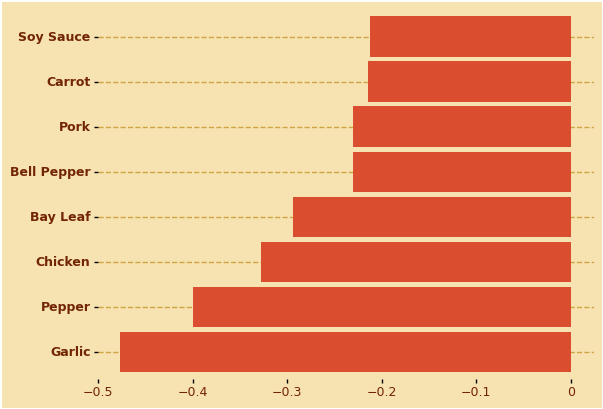

<ggplot: (-9223371908886952879)>

In [9]:
def custom_color(x):
    if x < 0:
        return '#DA4D2E'

plot_svd_ulam(data=weights_df,
              num_comp=1,
              num_ing=8,
              fill_fn=np.vectorize(custom_color),
              manual_fill_values=['#DA4D2E'])

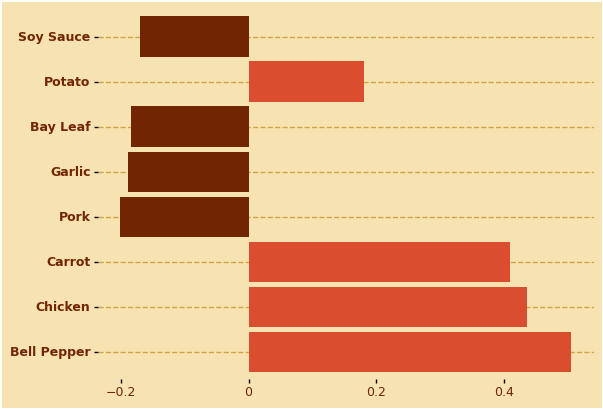

<ggplot: (127968974116)>

In [10]:
def custom_color(x):
    if x < 0:
        return '#722502'
    if x > 0:
        return '#DA4D2E'

plot_svd_ulam(data=weights_df,
              num_comp=2,
              num_ing=8,
              fill_fn=np.vectorize(custom_color),
              manual_fill_values=['#722502', '#DA4D2E'])

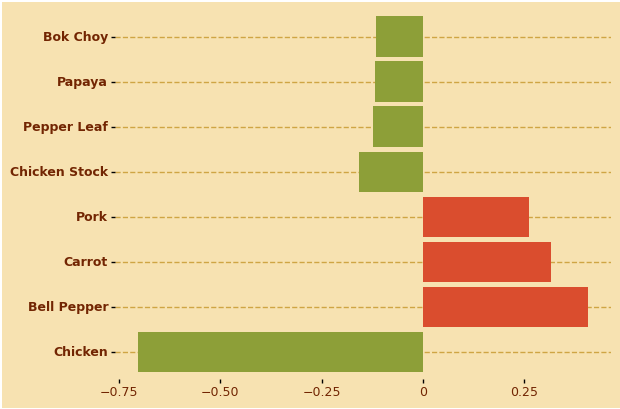

<ggplot: (-9223371908884744125)>

In [11]:
import re
def custom_color(x):
    if x < 0:
        return '#8D9F38'
    if x > 0:
        return '#DA4D2E'
    
plot_svd_ulam(data=weights_df,
              num_comp=3,
              num_ing=8,
              fill_fn=np.vectorize(custom_color),
              manual_fill_values=['#8D9F38', '#DA4D2E'])

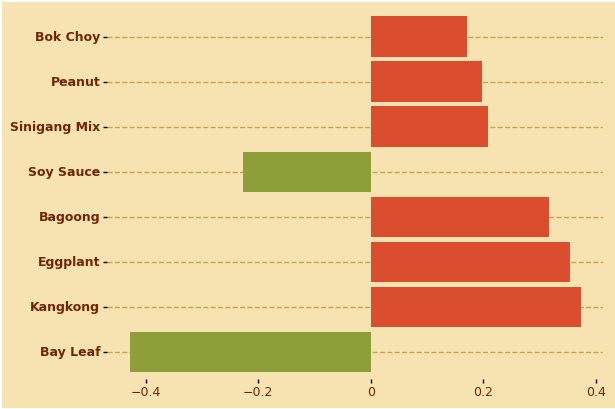

<ggplot: (-9223371908884784405)>

In [12]:
def custom_color(x):
    if x < 0:
        return '#8D9F38'
    if x > 0:
        return '#DA4D2E'
    
plot_svd_ulam(data=weights_df,
              num_comp=4,
              num_ing=8,
              fill_fn=np.vectorize(custom_color),
              manual_fill_values=['#8D9F38', '#DA4D2E'])

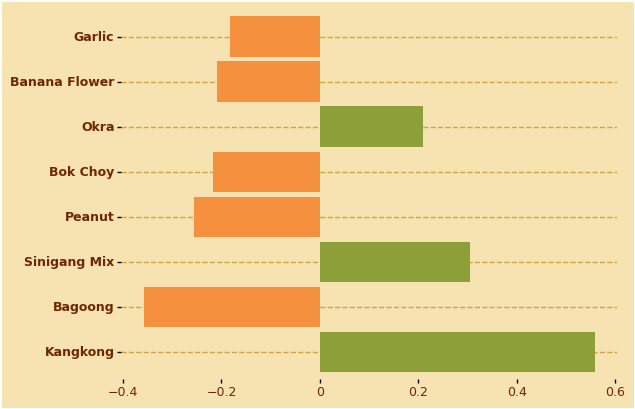

<ggplot: (-9223371908884746110)>

In [13]:
def custom_color(x):
    if x < 0:
        return '#5E6A25'
    if x > 0:
        return '#8D9F38'
func = np.vectorize(custom_color)

plot_svd_ulam(data=weights_df,
              num_comp=5,
              num_ing=8,
              fill_fn=np.vectorize(custom_color),
              manual_fill_values=['#F4903E', '#8D9F38'])

# 4a. Hierarchical Clustering (Wards)

In [330]:
from scipy.cluster import hierarchy

def final_clustering(transformed_arr,
                     orig_df,
                     method,
                     threshold,
                     plot_threshold,
                     break_biggest_cluster = False,
                     link_colors=['#5594BA',
                                  '#EFC564',
                                  '#DA4D2E',
                                  '#722502',
                                  '#EFC564',
                                  '#B3C55A']):
    
    Z = hierarchy.linkage(transformed_arr, method=method, optimal_ordering=True)
    hierarchy.set_link_color_palette(link_colors)
    y_pred = fcluster(Z, t=threshold, criterion='distance')
    
    if break_biggest_cluster:
        X_cluster = orig_df.copy()
        X_cluster['cluster'] = y_pred
        
        get_big_cluster = X_cluster.groupby(['cluster']).size().idxmax()
        X_1 = X_cluster[X_cluster.cluster == get_big_cluster].drop(columns='cluster')
        Z_1 = linkage(X_1, method='ward', optimal_ordering=True)
        Z = Z_1
        
    fig, ax = plt.subplots(figsize=(10,6), dpi=150)

    fig.patch.set_facecolor('#F7E2B1')
    fig.patch.set_alpha(0.6)
    ax.patch.set_facecolor('#F7E2B1')
    ax.patch.set_alpha(0.0)

    ax.spines['bottom'].set_color('#722502')
    ax.spines['top'].set_color('#722502') 
    ax.spines['right'].set_color('#722502')
    ax.spines['left'].set_color('#722502')
    ax.tick_params(axis='x', colors='#722502')
    ax.tick_params(axis='y', colors='#722502')
    ax.set_ylabel(r'$\Delta$')

    dn = dendrogram(Z, ax=ax, p=plot_threshold, truncate_mode='level')
    fig.show()
    
    return Z

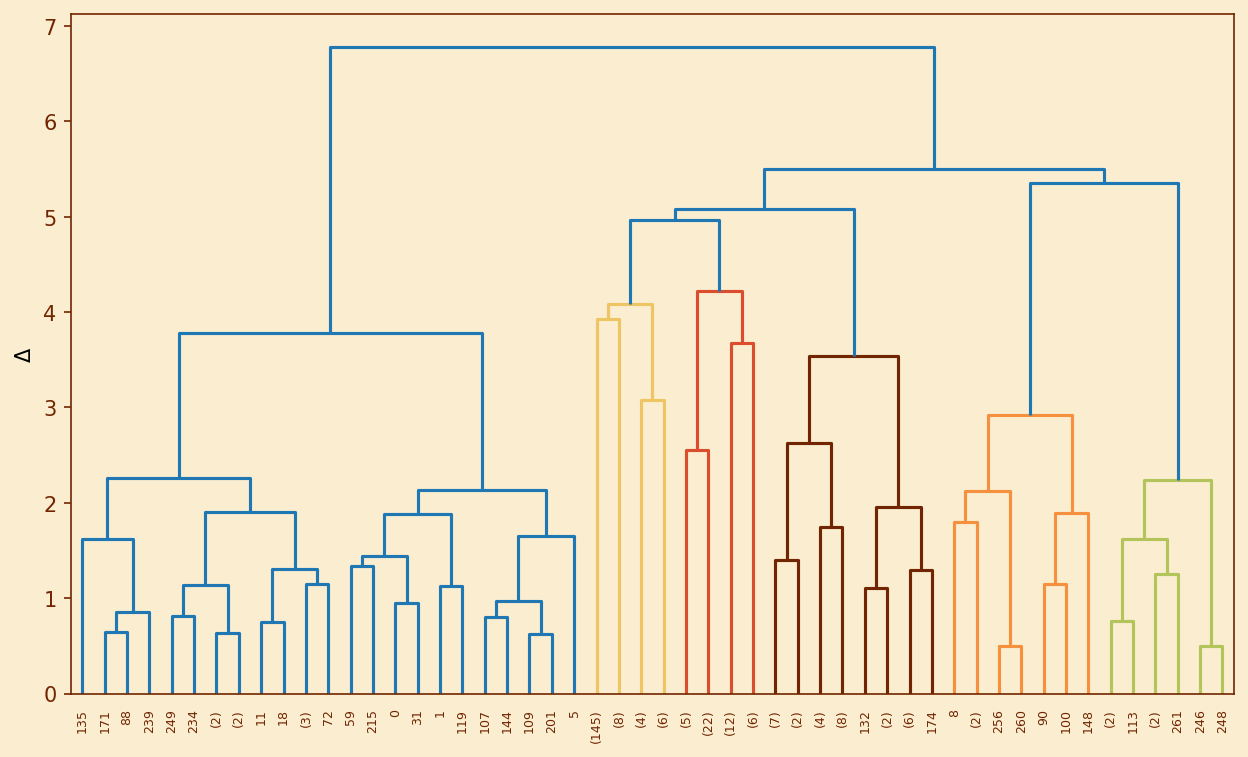

In [331]:
orig_df = pd.DataFrame(X, index=df_ing.dish_name, columns=dropped_df.columns)
Z = final_clustering(X_new, orig_df, 'ward', 4.5, 5, False,
                 link_colors=['#1F77B4',
                              '#EFC564',
                              '#DA4D2E',
                              '#722502',
                              '#F4903E',
                              '#B3C55A'])
y_pred = fcluster(Z, t=4.5, criterion='distance')
X_cluster = orig_df.assign(cluster=y_pred)

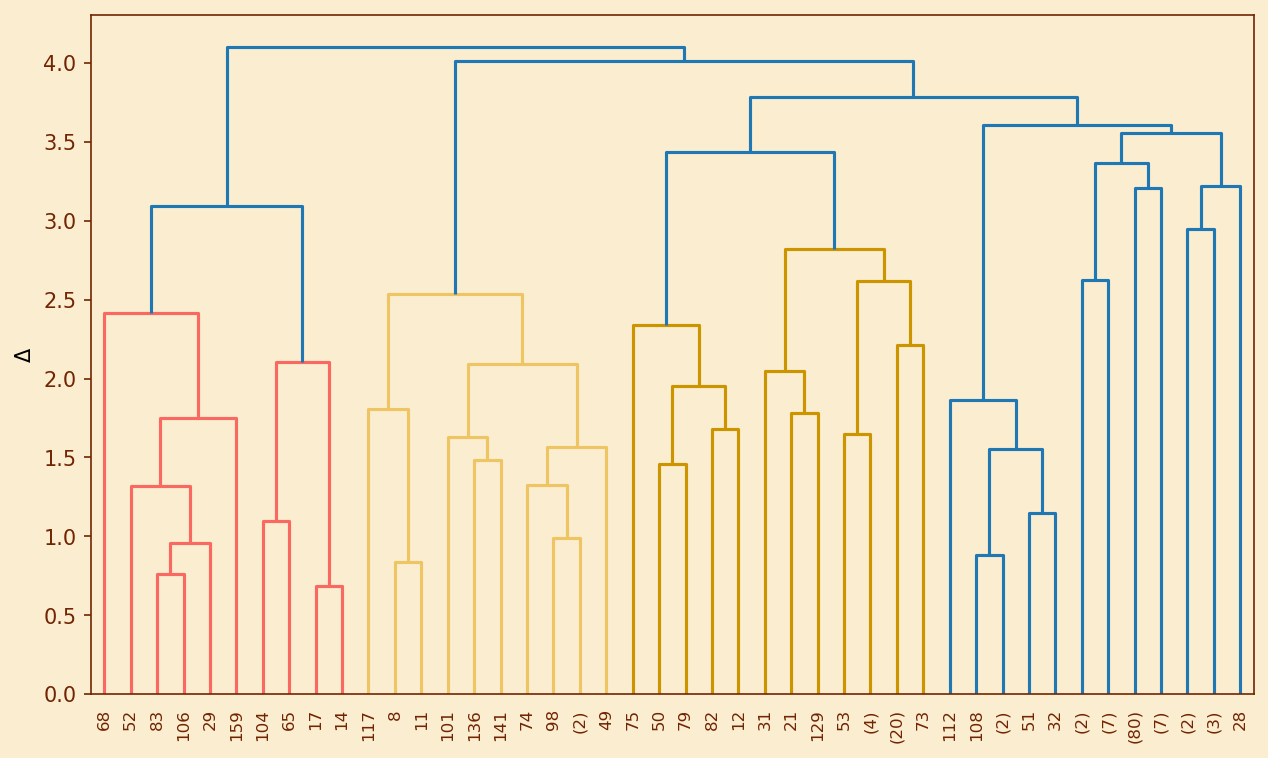

In [332]:
Z_1 = final_clustering(X_new, orig_df, 'ward', 4.5, 6, break_biggest_cluster=True,
                 link_colors=['#FA6961',
                              '#FA6961',
                              '#EFC564',
                              '#CC9500',
                              '#CC9500',
                              '#1F77B4',
                              '#1F77B4'])
y_pred_1 = fcluster(Z_1, t=3.7, criterion='distance')
get_big_cluster = X_cluster.groupby(['cluster']).size().idxmax()
X_cluster_1 = X_cluster[X_cluster.cluster == get_big_cluster].drop(columns='cluster')
X_cluster_1['cluster'] = y_pred_1 + 6

In [333]:
X_cluster.loc[X_cluster_1.index] = X_cluster_1
renumber_cluster = dict(zip(sorted(X_cluster['cluster'].unique()), range(9)))
X_cluster['cluster_no'] = X_cluster['cluster'].map(renumber_cluster).astype(str)
X_new_df = pd.DataFrame(X_new)
X_new_df.columns = [f'SV{i+1}' for i in X_new_df.columns]
X_new_df['cluster_no'] = list(X_cluster['cluster_no'])
X_cluster_1

,yeast,wrapper,worcestershire_sauce,winged_bean,vinegar,tomato,tofu,toasted_rice_powder,taro,sweet_potato,...,pineapple,water,salt,rice,pork,corn,chicken,beef,banana,cluster
dish_name,,,,,,,,,,,,,,,,,,,,,
Chicken Barbecue,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.333333,0.0,0.0,0.0000,0.003527,0.000000,0.0,9
Spicy Sotanghon Chicken Soup,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.125000,0.000000,0.0,0.0,0.0000,0.600000,0.000000,0.0,10
Chicken Sotanghon Soup with Malunggay and Sayote,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.250000,0.000000,0.0,0.0,0.0000,0.400000,0.000000,0.0,10
Chicken Lollipop Recipe,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.500000,0.0,0.0,0.0000,0.008818,0.000000,0.0,10
Chicken Mami Recipe,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.250000,0.000000,0.0,0.0,0.0000,0.001323,0.000000,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Papaitan Recipe,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.250000,0.026042,0.0,0.0,0.0000,0.000000,0.071429,0.0,10
Morcon Recipe,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000868,0.0,0.0,0.0000,0.000000,0.285714,0.0,7
Beef Mechado Recipe,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.031250,0.166667,0.0,0.0,0.0000,0.000000,0.285714,0.0,10


In [334]:
clusters = X_cluster.reset_index().groupby('cluster_no')['dish_name'].unique()
for k, v in enumerate(clusters):
    print(f'Cluster {k}')
    print(v)
    print('--------')

Cluster 0
['Sinarsahang Manok' 'Pinoy Chicken Curry Recipe' 'Chicken Igado'
 'Pineapple Chicken Afritada'
 'Pininyahang Manok sa Gata (Pineapple Chicken in Coconut Milk)'
 'Chicken Caldereta' 'Sarciadong Manok' 'Healthy Chicken Menudo'
 'Chicken Curry'
 'Special Chicken Embutido Recipe (Filipino Chicken Meatloaf)'
 'Chicken Afritada with Bell Pepper' 'Pork Caldereta Recipe'
 'Pork Menudo sa Gata' 'Spareribs Kaldereta'
 'Pinoy Pork and Chicken Curry' 'Pork Kaldereta sa Gata'
 'Spicy Pork Kaldereta' 'Calderetang Baboy Recipe'
 'Special Pork Kaldereta' 'Afritadang Baboy Recipe'
 'Pork Menudo with Ham Recipe' 'Pork Mechado Recipe'
 'KBL (Kadyos, Baboy, at Langka) Recipe'
 'Beef Kaldereta sa Gata with Peanut Butter' 'Beef Kaldereta Recipe'
 'Mechadong Baka Recipe' 'How To Cook Beef Kaldereta']
--------
Cluster 1
['Chicken Binagoongan Recipe'
 'Pininyahang Manok Recipe (Pineapple Chicken)'
 'Chicken Feet in Oyster Sauce with Salted Black Beans'
 'Maxs Style Fried Chicken with Kamote Fries'
 

# 4b. Cluster Plots

In [19]:
def custom_color(x):
    if x == '0': 
        return '#DA4D2E' # carrot + patatas, ma-sarsa
    elif x == '3':
        return '#F4903E' # dahon, ma-sarsa
    elif x == '4':
        return '#8D9F38' # dahon, ma-sabaw
    elif x == '6':
        return '#EFC564' # carrot + patatas, ma-sabaw
    else:
        return '#D7D7D7'
    
def custom_alpha(x):
    if x == '0': 
        return '1' # carrot + patatas, ma-sarsa
    elif x == '3':
        return '1' # dahon, ma-sarsa
    elif x == '4':
        return '1' # dahon, ma-sabaw
    elif x == '6':
        return '1' # carrot + patatas, ma-sabaw
    else:
        return '0'  
    
func = np.vectorize(custom_color)
X_new_df['plot1_colors'] = func(X_new_df['cluster_no'])
func = np.vectorize(custom_alpha)
X_new_df['plot1_alphas'] = func(X_new_df['cluster_no'])

In [20]:
def custom_color(x):
    if x == '2': 
        return '#722502' # suka + toyo, maalat
    elif x == '7':
        return '#6A687A' # suka + toyo, matamis
    elif x == '5':
        return '#FA6961' # tomato-based, matamis
    else:
        return '#D7D7D7'
    
def custom_alpha(x):
    if x == '2': 
        return '1' # carrot + patatas, ma-sarsa
    elif x == '7':
        return '1' # dahon, ma-sarsa
    elif x == '5':
        return '1' # dahon, ma-sabaw
    else:
        return '0'
    
func = np.vectorize(custom_color)
X_new_df['plot2_colors'] = func(X_new_df['cluster_no'])
func = np.vectorize(custom_alpha)
X_new_df['plot2_alphas'] = func(X_new_df['cluster_no'])

In [119]:
p = (ggplot(X_new_df, aes(x='SV2', y='SV5'))+
    geom_hline(yintercept=0, color='#722502', size=1.5, linetype='dashed', alpha=0.5)+
    geom_vline(xintercept=0, color='#722502', size=1.5, linetype='dashed', alpha=0.5)+
    geom_point(aes(color='plot1_colors', alpha='plot1_alphas'), size=8, show_legend=False) +
    scale_color_manual(values=['#8D9F38', '#F9F8FC', '#DA4D2E', '#EFC564', '#F4903E']) +
    scale_alpha_manual(values=[0.25, 1]) +
    xlab('') + ylab('') +
    xlim(-1,1)+
    proj_theme3
)
# p.save(filename = "plot1.png", width = 10.5, height=10.5, units='in')
# p

In [124]:
p = (ggplot(X_new_df, aes(x='SV2', y='SV5'))+
    geom_point(aes(color='plot2_colors', alpha='plot2_alphas'), size=8, show_legend=False) +
     geom_hline(yintercept=0, color='#722502', size=1.5, linetype='dashed', alpha=0.5)+
    geom_vline(xintercept=0, color='#722502', size=1.5, linetype='dashed', alpha=0.5)+
    scale_color_manual(values=['#e3a600', '#722502', '#F9F8FC', '#FA6961']) +
    scale_alpha_manual(values=[0.25, 1]) +
    xlab('') + ylab('') +
    xlim(-1,1)+
    proj_theme3
)
# p.save(filename = "plot2.png", width = 10.5, height=10.5, units='in')
# p

In [125]:
p = (ggplot(X_new_df, aes(x='SV2', y='SV5'))+
    geom_point(aes(color='plot2_colors', alpha='plot2_alphas'), size=8, show_legend=False) +
     geom_hline(yintercept=0, color='#722502', size=1.5, linetype='dashed', alpha=0.5)+
    geom_vline(xintercept=0, color='#722502', size=1.5, linetype='dashed', alpha=0.5)+
    scale_color_manual(values=['#e3a600', '#722502', '#F9F8FC', '#FA6961']) +
    scale_alpha_manual(values=[0.25, 1]) +
    xlab('') + ylab('') +
    xlim(-1,1)+
    coord_cartesian(ylim = [-0.40, 0.40], xlim = [-0.75, 0.75]) +
    proj_theme3
)
# p.save(filename = "plot2_zoomed.png", width = 10.5, height = 10.5)
# p

# Plotly

In [126]:
def custom_color(x):
    if x == '0': 
        return '#DA4D2E' # carrot + patatas, ma-sarsa
    elif x == '3':
        return '#F4903E' # dahon, ma-sarsa
    elif x == '4':
        return '#8D9F38' # dahon, ma-sabaw
    elif x == '6':
        return '#EFC564' # carrot + patatas, ma-sabaw
    elif x == '2': 
        return '#722502' # suka + toyo, maalat
    elif x == '7':
        return '#cc9500' # suka + toyo, matamis
    elif x == '5':
        return '#FA6961' # tomato-based, matamis
    else:
        return 'rgba(249, 248, 252, 0.4)'

func = np.vectorize(custom_color)
X_new_df['plotly_colors'] = func(X_new_df['cluster_no'])

def custom_names(x):
    if x == '0': 
        return 'Saucy Crops' # carrot + patatas, ma-sarsa
    elif x == '3':
        return 'Nutty Sauce' # dahon, ma-sarsa
    elif x == '4':
        return 'Sour Soup' # dahon, ma-sabaw
    elif x == '6':
        return 'Salty Soup' # carrot + patatas, ma-sabaw
    elif x == '2': 
        return 'Soy Vinegar' # suka + toyo, maalat
    elif x == '7':
        return 'Soy Sweet' # suka + toyo, matamis
    elif x == '5':
        return 'Red Sweet' # tomato-based, matamis
    else:
        return 'Others'
    
func = np.vectorize(custom_names)
X_new_df['cluster_names'] = func(X_new_df['cluster_no'])
X_new_df['cluster_names'] = pd.Categorical(X_new_df['cluster_names'], ['Saucy Crops', 'Nutty Sauce', 'Sour Soup', 'Salty Soup', 'Soy Vinegar', 'Soy Sweet', 'Red Sweet', 'Others'], ordered=True)

In [114]:
X_new_df['Dish Name'] = X_cluster.index
dict_df = X_new_df[['cluster_no', 'plotly_colors']].drop_duplicates()
c_map = dict(zip(dict_df['cluster_no'], dict_df['plotly_colors']))

In [113]:
data = X_new_df
x = 'SV2'
y = 'SV5'
c = 'cluster_names'
tooltip = ['Dish Name']
y_ref = 0
x_ref = 0

fig = px.scatter(data.sort_values('cluster_names'),
                 x=x,
                 y=y,
                 color=c,
                 hover_data=tooltip,
                 labels={
                     x: '<b>Vegetable Range</b>',
                     y: '<b>Flavor Range</b>',
                     c: '<b>Cluster</b>',
                     'Dish Name': '<b>Dish Name</b>'},
                 color_discrete_map=cmap,
                 width=1000, height=800)
fig.update_traces(marker={'size': 14})
fig.for_each_trace(lambda t: t.update(textfont_color='#99D072',
                                       textposition='top right'))
fig.add_shape(
    yref='y',
    y0=y_ref,
    y1=y_ref,   # adding a horizontal line at Y = 1
    xref='paper',
    x0=0,
    x1=1,
    line=dict(
        color='rgba(114, 37, 2, 0.5)',
        width=2.5)
)
fig.add_shape(
    type='line',
    yref='paper',
    y0=0,
    y1=1,
    xref='x',
    x0=x_ref,
    x1=x_ref,
    line=dict(
        color='rgba(114, 37, 2, 0.5)',
        width=2.5)
)
fig.update_layout(
    title={'text': f"<b>What's in your ulam, pare?</b>",
           'xanchor': 'center',
           'yanchor': 'top',
           'x': 0.5},
    margin=dict(l=0, r=0, t=100, b=0),
    font={'size': 20, 'color': '#722502'},
    plot_bgcolor='#F7E2B1',
    xaxis_range=[-1, 1],
    yaxis_range=[-1, 1],
    paper_bgcolor='#F7E2B1'
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='#722502', gridcolor='#F7E2B1')
fig.update_yaxes(showline=True, linewidth=2, linecolor='#722502', gridcolor='#F7E2B1')
fig.show()

In [78]:
import plotly.io as pio
pio.write_html(fig, file='try.html', auto_open=True)

# SCRATCH

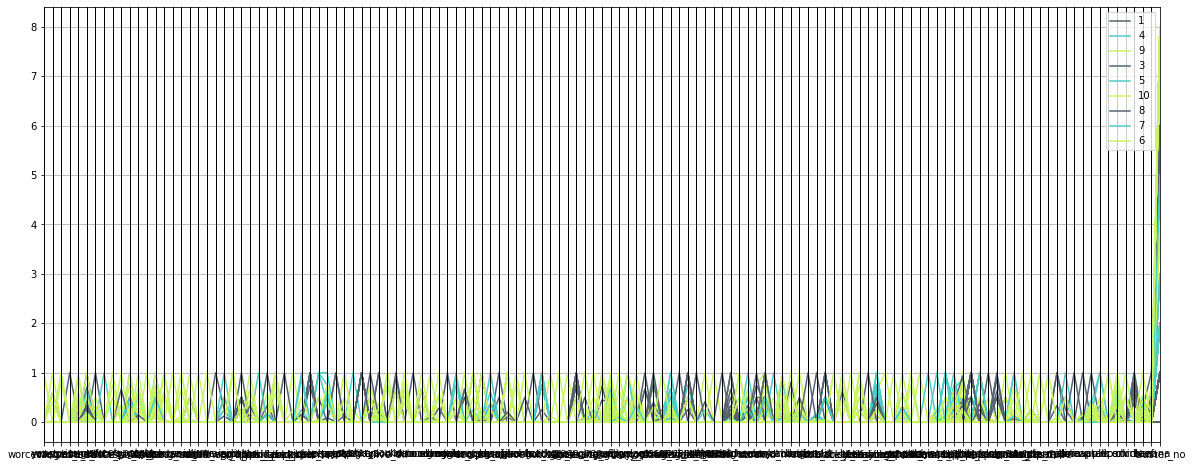

In [27]:
fig = plt.figure(figsize=(20,8))
pd.plotting.parallel_coordinates(
    X_cluster, 'cluster', color=('#556270', '#4ECDC4', '#C7F464'), 
    figure=fig
);

<AxesSubplot:>

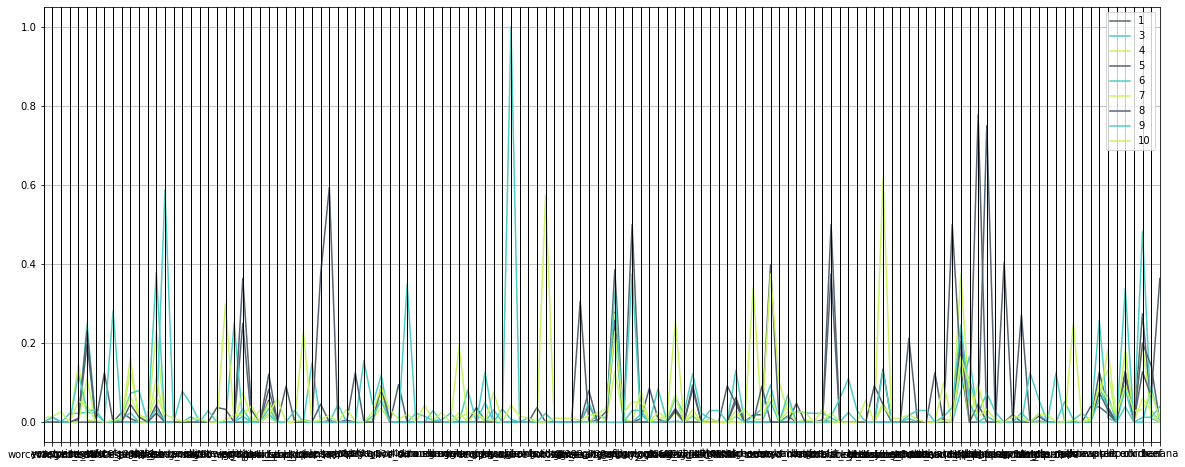

In [28]:
X_means =  X_cluster.groupby("cluster").mean()

X_means = X_means.reset_index()
fig = plt.figure(figsize=(20,8))
pd.plotting.parallel_coordinates(
    X_means, 'cluster', color=('#556270', '#4ECDC4', '#C7F464'),figure=fig, 
)

In [29]:
# # def ind_color(x):
# # #     if x == '2': 
# # #         return '#DA4D2E' # carrot + patatas, ma-sarsa
# #     if x == '7':
# #         return '#F4903E' # dahon, ma-sarsa
# # #     elif x == '5':
# # #         return '#8D9F38' # dahon, ma-sabaw
# #     else:
# #         return '#D7D7D7'

# # func = np.vectorize(ind_color)
# # X_new_df['ind_color'] = func(X_new_df['cluster_no'])

# (ggplot(X_new_df, aes(x='SV2', y='SV5'))+
#     geom_point(aes(color='ind_color')) +
#     #scale_color_manual(values=['#DA4D2E', '#8D9F38', '#F4903E', '#8D9F38', '#EFC564']) +
#     proj_theme
# )

# # first - '#8D9F38'
# # third - '#DA4D2E'
# # fourth - '#EFC564'
# # fifth - '#F4903E'

# # first - '#F4903E'
# # second - '#DA4D2E' 
# # third - '#8D9F38'